---
title: 04 - Plots for cell type predictions, mouse
author: Naz Salehin, Martin Proks
date: 27-11-2024
model: v1.0
---

In [1]:
!which pip

~/projects/data/Brickman/conda/envs/scvi-1.1.5/bin/pip


In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import scvi
import anndata
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt

plt.rcParams['svg.fonttype'] = 'none'

lineage_colors = {
    'Zygote': '#7985A5',
    '2C': '#B3C81E',
    '4C': '#67BB30',
    '8C': '#028A46',
    '16C': '#657cbd',
    'ICM': '#F6C445',
    'TE': '#5a94ce',
    'EPI': '#B46F9C',
    'PrE': '#D05B61'
}

mouse_ct_colors = {
    'Zygote': '#7985A5',
    '2C': '#B3C81E',
    '4C': '#67BB30',
    '8C': '#028A46',
    '16C': '#657cbd',
    'E3.25-ICM': '#fadc8f',
    'E3.25-TE': '#5185b9',
    'E3.5-ICM': '#f8d06a',
    'E3.5-TE': '#7ba9d8',
    'E3.5-EPI': '#c38cb0',
    'E3.5-PrE': '#d97c81',
    'E3.75-ICM': '#F6C445',
    'E4.5-TE': '#5a94ce',
    'E4.5-EPI': '#B46F9C',
    'E4.5-PrE': '#D05B61',
    'Unknown': 'lightgrey'
}

In [3]:
import sys; sys.path.append("../scripts/")
from helpers import normalize_smartseq

In [ ]:
mouse = sc.read_h5ad("/home/fdb589/Brickman/projects/proks-salehin-et-al-2023/data/processed/01_mouse_reprocessed.h5ad")
mouse.obs['ct_custom'] = mouse.obs.ct.replace('E3.75-ICM', 'Unknown')

# sc.pp.highly_variable_genes(mouse, flavor="cell_ranger", n_top_genes=3_000, batch_key="batch", subset=True)
sc.pp.highly_variable_genes(mouse, flavor="seurat_v3", n_top_genes=3_000, batch_key="batch", layer='counts', subset=True)
mouse.obs['batch_og'] = mouse.obs['batch']
mouse.obs['batch'] = mouse.obs.batch
# mouse.obs['batch'] = mouse.obs.technology.cat.codes.astype(str) + "_" + mouse.obs.batch.cat.codes.astype(str)
# mouse.obs['batch'] = mouse.obs.technology.cat.codes.astype(str) + "_" + mouse.obs.experiment.cat.codes.astype(str) + mouse.obs.batch.cat.codes.astype(str)

scvi.model.SCVI.setup_anndata(mouse, layer="counts", batch_key="batch")
vae = scvi.model.SCVI(mouse, n_layers=2, gene_likelihood='nb')
vae.train(max_epochs=400, early_stopping=True)

lvae = scvi.model.SCANVI.from_scvi_model(vae, adata=mouse, labels_key="ct_custom", unlabeled_category="Unknown")
lvae.train(max_epochs=20, n_samples_per_label=15)

mouse.obsm['X_scVI'] = vae.get_latent_representation()
mouse.obsm['X_scANVI'] = lvae.get_latent_representation()

In [ ]:
mouse.obs['predictions'] = lvae.predict()
mouse.obs['predictions'] = mouse.obs['predictions'].astype('category')
mouse.obs['predictions_stages'] = [x.split('-')[-1] for x in mouse.obs.predictions]
mouse.obs['predictions_stages'] = mouse.obs['predictions_stages'].astype('category')

mouse.uns['predictions_colors'] = [mouse_ct_colors[ct] for ct in mouse.obs.predictions.cat.categories]
mouse.uns['predictions_stages_colors'] = [lineage_colors[ct] for ct in mouse.obs.predictions_stages.cat.categories]

In [ ]:
mouse.obs.query('ct == "E3.75-ICM"')['predictions'].value_counts()

In [ ]:
sc.pp.neighbors(mouse, use_rep='X_scVI')
sc.tl.umap(mouse)
sc.tl.diffmap(mouse)
sc.tl.paga(mouse, groups='predictions')
sc.pl.paga(mouse, color=['predictions'], frameon=False, fontoutline=True)
sc.tl.draw_graph(mouse, init_pos='paga', n_jobs=10)

In [ ]:
sc.pl.umap(mouse, color=['technology', 'predictions', 'predictions_stages'], wspace=0.3)
sc.pl.draw_graph(mouse, color=['technology', 'predictions', 'predictions_stages'], wspace=0.3)

In [ ]:
mouse.obs.value_counts(['technology', 'predictions']).unstack().fillna(0)

In [ ]:
vae.save("../results/12_mouse/scvi", overwrite=True, save_anndata=True)
lvae.save("../results/12_mouse/scanvi_ns15", overwrite=True, save_anndata=True)

In [ ]:
# ## Updated AI model

# vae = scvi.model.SCVI.load("../../proks-salehin-et-al-2023/results/02_mouse_integration/scvi/")

# # Retraining
# vae.adata.obs['ct_custom'] = vae.adata.obs.ct.replace('E3.75-ICM', 'Unknown')
# lvae = scvi.model.SCANVI.from_scvi_model(vae, labels_key="ct_custom", unlabeled_category="Unknown")
# lvae.train(n_samples_per_label=15)

# # lvae.save("../results/12_mouse/scanvi_ns_15", overwrite=True, save_anndata=True)

### Validations

In [ ]:
lvae = scvi.model.SCANVI.load('../results/12_mouse/scanvi_ns15')
lvae.adata.obs['predictions'] = lvae.predict()

In [ ]:
lvae.adata.obs.query('ct == "E3.75-ICM"')['predictions'].value_counts()

In [ ]:
order = ['Zygote', '2C', '4C', '8C', '16C', 'E3.25-ICM', 'E3.25-TE', 'E3.5-ICM',
         'E3.5-TE', 'E3.5-EPI', 'E3.5-PrE', 'E4.5-TE', 'E4.5-EPI', 'E4.5-PrE']
ax = sns.heatmap(
    sc.metrics.confusion_matrix('ct', 'predictions', lvae.adata.obs).loc[order, order],
    linewidths=0.2, cmap='viridis', square=True, linewidth=.5, linecolor='black'
)

## Niakan analysis

In [ ]:
GENE_LEN = '~/Brickman/shared/references/mus_musculus/ensembl/GRCm38_102/Mus_musculus_GRCm38_102_gene_length.txt'

# adata = sc.read_h5ad("../data/external/niakan_et_al/mouse/mtx_conversions/combined_matrix.h5ad")
adata = sc.read_h5ad("../data/assays/SCR_MP_20241207/processed/combined_matrix.h5ad")
adata.obs['LIMS.ID'] = adata.obs['sample'].str.split('_', expand=True).iloc[:, 0]
adata.obs = adata.obs.merge(pd.read_csv("../data/assays/SCR_MP_20241207/raw/Samples_LIMSID_Mouse.csv"), 
                            left_on='sample', right_on='LIMS.ID', how='left').set_index(adata.obs_names)
adata.obs['batch'] = 'NIAKAN_' + adata.obs['Plate.no'].astype(str)
adata.obs['experiment'] = "Simon et al, 2024"
adata.obs['technology'] = "SMART-seq2"

adata = adata[~adata.obs['sample'].isin(['SIM5111A40', 'SIM5111A48'])]
adata = adata[adata.obs.QC == "Pass"]
adata = adata[~adata.obs.Treatment.isna()].copy()

adata.var['mt'] = adata.var.gene_symbol.str.startswith('mt-')
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

adata = adata[adata.obs.pct_counts_mt < 25].copy()

adata = normalize_smartseq(adata, GENE_LEN)

adata.var['gene_id'] = adata.var_names
adata.var_names = adata.var.gene_symbol.str.lower().values
adata.var_names_make_unique()

adata.layers["counts"] = adata.X.copy()
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
adata.raw = adata

sc.pp.highly_variable_genes(adata, flavor="cell_ranger", n_top_genes=3_000, batch_key="batch")
sc.tl.pca(adata)

sc.pl.pca(adata, color='Treatment')
display(adata.obs.Treatment.value_counts())

adata.write('../results/12_niakan.mouse.h5ad')

### Prediction

In [4]:
mouse_query = sc.read_h5ad('../results/12_niakan.mouse.h5ad')
del mouse_query.varm['PCs']

lvae = scvi.model.SCANVI.load("../results/12_mouse/scanvi_ns15")

scvi.model.SCANVI.prepare_query_anndata(mouse_query, lvae)
lvae_q = scvi.model.SCANVI.load_query_data(mouse_query, lvae)
lvae_q.train(max_epochs=100, plan_kwargs=dict(weight_decay=0.0), check_val_every_n_epoch=10, early_stopping=True)

Trainer will use only 1 of 4 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=4)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.


INFO     File ../results/12_mouse/scanvi_ns15/model.pt already downloaded                                          


/home/fdb589/projects/data/Brickman/conda/envs/scvi-1.1.5/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fdb589/projects/data/Brickman/conda/envs/scvi- ...
/home/fdb589/projects/data/Brickman/conda/envs/scvi-1.1.5/lib/python3.10/site-packages/scvi/model/base/_utils.py:66: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary

INFO     Found 84.83333333333334% reference vars in query data.                                                    


/home/fdb589/projects/data/Brickman/conda/envs/scvi-1.1.5/lib/python3.10/site-packages/anndata/_core/merge.py:1362: UserWarning: Only some AnnData objects have `.raw` attribute, not concatenating `.raw` attributes.
  warn(
Trainer will use only 1 of 4 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=4)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.


INFO     Training for 100 epochs.                                                                                  


/home/fdb589/projects/data/Brickman/conda/envs/scvi-1.1.5/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fdb589/projects/data/Brickman/conda/envs/scvi- ...
/home/fdb589/projects/data/Brickman/conda/envs/scvi-1.1.5/lib/python3.10/site-packages/scvi/data/_manager.py:215: UserWarning: Missing labels key ct_custom. Filling in with unlabeled category Unknown.
  field_registry[_constants._STATE_REGISTRY_KEY] = field.transfer_field(
Trainer will use only 1 of 4 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=4)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
/home/fdb589/projects/data/Brickman/conda/envs/scvi-1.1.5/lib/python3.1

Epoch 91/100:  91%|█████████ | 91/100 [00:02<00:00, 32.87it/s, v_num=1, train_loss_step=1.51e+4, train_loss_epoch=1.51e+4]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: 13435.031. Signaling Trainer to stop.


In [5]:
mouse_query = sc.read_h5ad('../results/12_niakan.mouse.h5ad')
mouse_query.obsm["X_scANVI"] = lvae_q.get_latent_representation()
mouse_query.obs['predictions'] = lvae_q.predict()

# remove TE cells
# mouse_query = mouse_query[~mouse_query.obs.predictions.str.contains('TE')].copy()

mouse_query.obs['predictions'] = mouse_query.obs['predictions'].astype('category')
mouse_query.obs['entropy'] = 1 - lvae_q.predict(soft=True).max(axis=1)

mouse_query.uns['predictions_colors'] = [mouse_ct_colors[ct] for ct in mouse_query.obs.predictions.cat.categories]

### PCA/UMAP

In [6]:
sc.pp.neighbors(mouse_query)
sc.tl.pca(mouse_query)
sc.tl.umap(mouse_query)

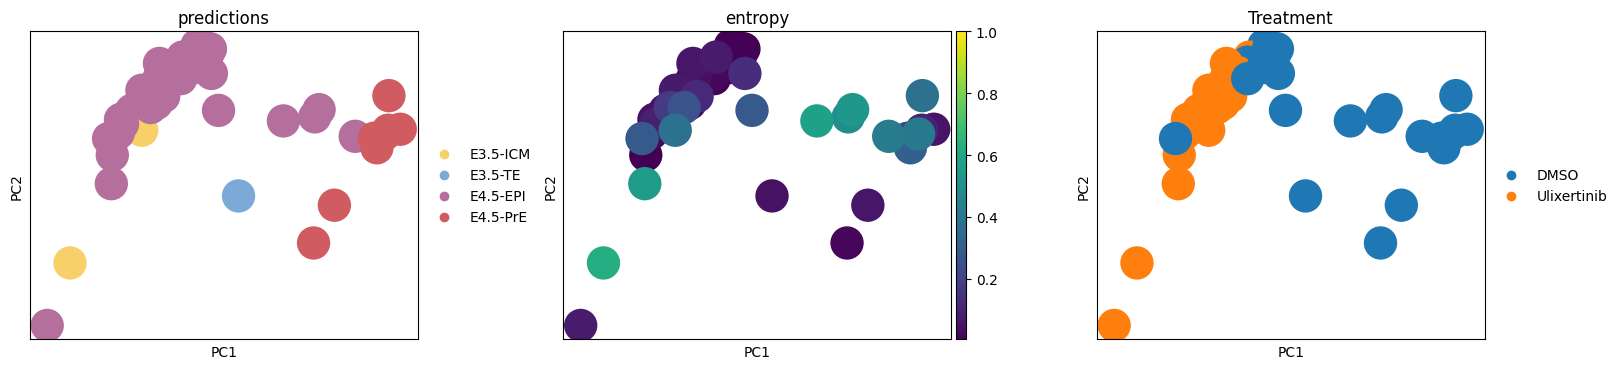

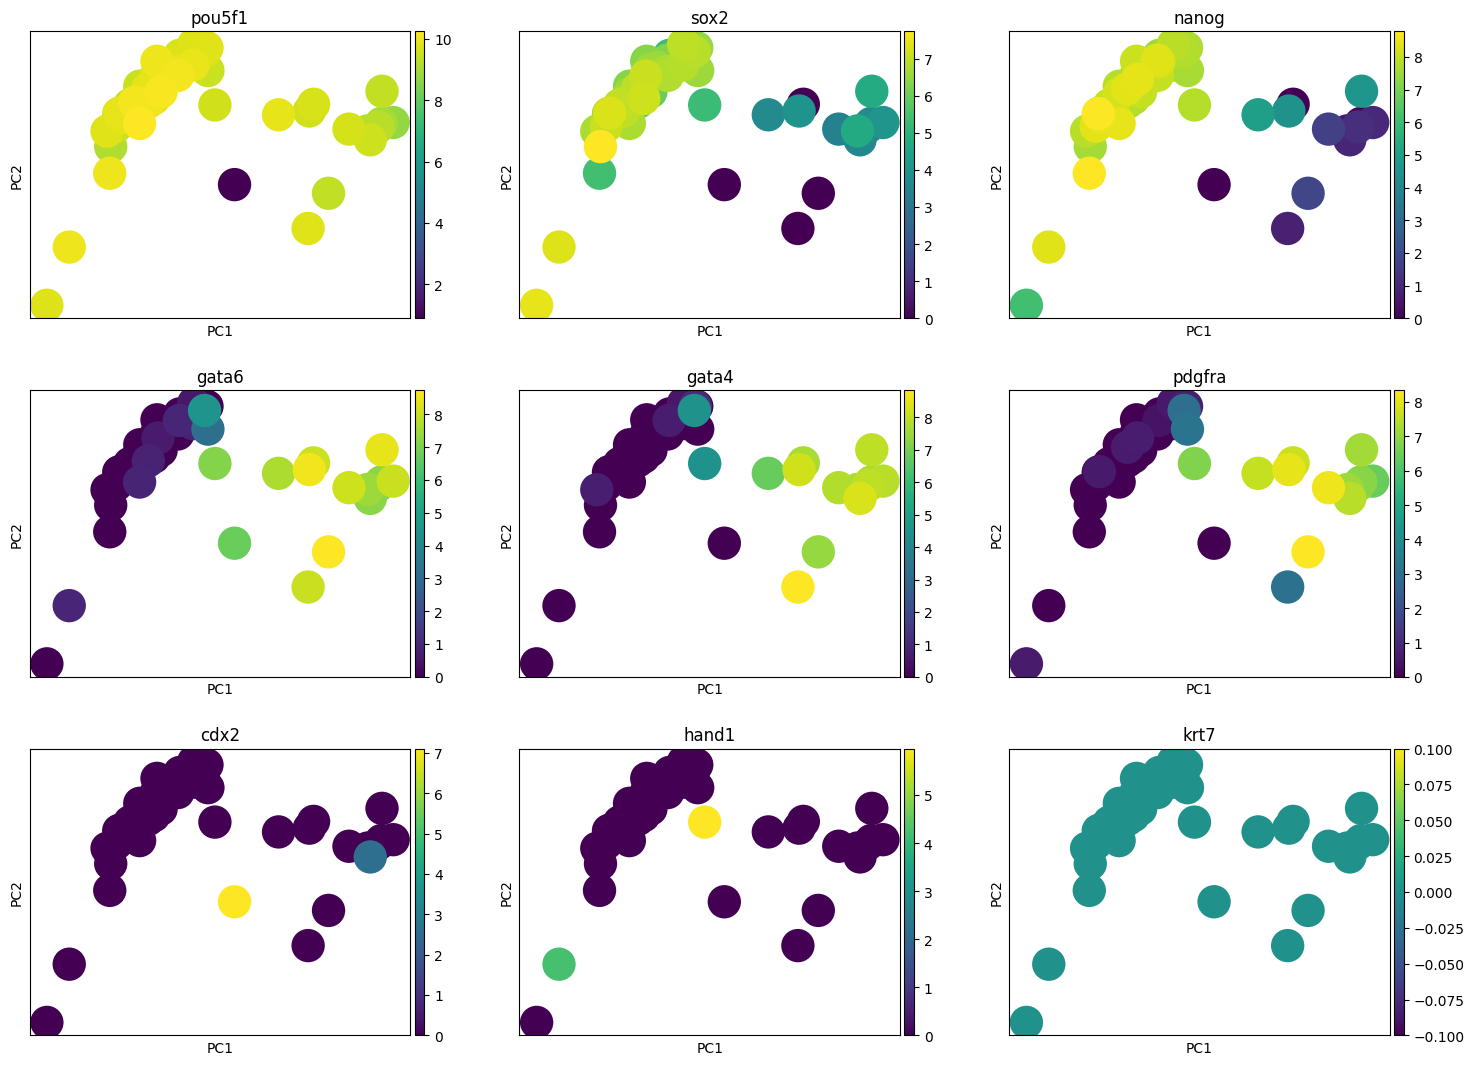

In [7]:
plt.rcParams['figure.figsize'] = [5, 4]
ax = sc.pl.pca(mouse_query, color = ['predictions', 'entropy', 'Treatment'], wspace=0.25, vmax=1, return_fig=True)
ax.savefig('../figures/12_niakan_mouse_PCA.pdf')

ax = sc.pl.pca(mouse_query, color = [
    'pou5f1', 'sox2', 'nanog',
    'gata6', 'gata4', 'pdgfra',
    'cdx2', 'hand1', 'krt7'
    ], ncols=3, return_fig=True)
ax.savefig('../figures/12_niakan_mouse_PCA_markers.pdf')

NameError: name 'adata' is not defined

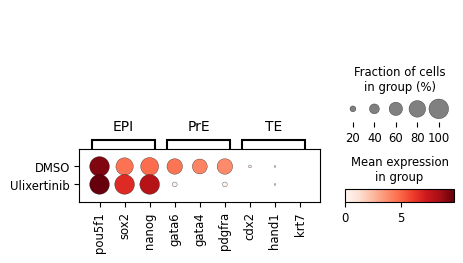

In [8]:
markers = {
    'EPI': ['pou5f1', 'sox2', 'nanog'],
    'PrE': ['gata6', 'gata4', 'pdgfra'],
    'TE': ['cdx2', 'hand1', 'krt7']
}

ax = sc.pl.dotplot(mouse_query, markers, groupby='Treatment', return_fig=True)
ax.savefig('../figures/12_niakan_mouse_dotplot_markers.pdf')

ax = sc.pl.matrixplot(adata, markers, groupby='Treatment', dendrogram=True, return_fig=True)
ax.savefig('../figures/12_niakan_mouse_matrixplot_markers.pdf')

In [ ]:
# plt.rcParams['figure.figsize'] = [5, 4]
# ax = sc.pl.umap(mouse_query, color=['predictions'], s=120, return_fig = True)
# ax.savefig('../figures/niakan_12_mouse_UMAP_01.pdf')

In [ ]:
# plt.rcParams['figure.figsize'] = [5, 4]
# ax = sc.pl.umap(mouse_query, color=['Treatment'], s=120, return_fig = True)
# ax.savefig('../figures/niakan_12_mouse_UMAP_02.pdf')

predictions,E3.5-ICM,E3.5-TE,E4.5-EPI,E4.5-PrE
Treatment,,,,
DMSO,0,1,17,8
Ulixertinib,2,0,24,0


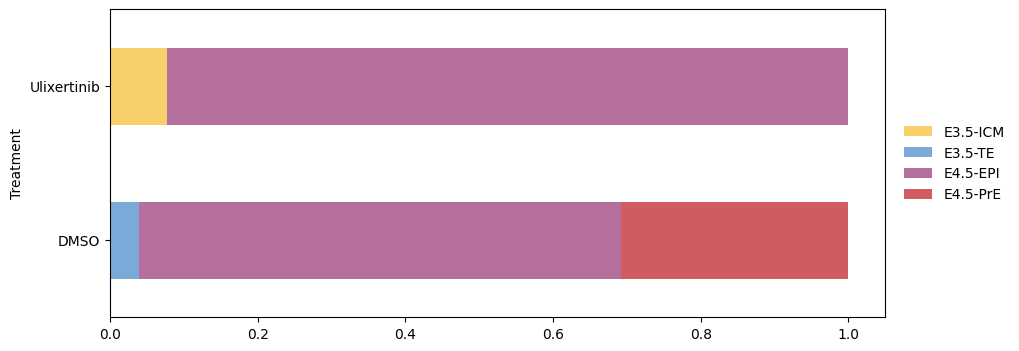

In [9]:
plt.rcParams['figure.figsize'] = [10, 4]
cmtx = sc.metrics.confusion_matrix('Treatment', 'predictions', normalize=True, data=mouse_query.obs)
ax = cmtx.plot(kind='barh',legend=True, stacked=True, color=mouse_ct_colors)
ax.legend(cmtx.columns, loc='center right', bbox_to_anchor=(1.17, 0.5), frameon=False)
ax.figure.savefig('../figures/niakan_12_mouse_Proportions_withLegend.pdf')

display(sc.metrics.confusion_matrix('Treatment', 'predictions', normalize=False, data=mouse_query.obs))

In [10]:
mouse_query.write('../results/12_niakan.mouse.withPredictions.h5ad')

## Integration with mouse dataset

In [11]:
lvae = scvi.model.SCANVI.load('../results/12_mouse/scanvi_ns15')
lvae.adata.obs['predictions'] = lvae.predict()

lvae_q.adata.obs['predictions'] = mouse_query.obs.predictions

Trainer will use only 1 of 4 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=4)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.


INFO     File ../results/12_mouse/scanvi_ns15/model.pt already downloaded                                          


/home/fdb589/projects/data/Brickman/conda/envs/scvi-1.1.5/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fdb589/projects/data/Brickman/conda/envs/scvi- ...
/home/fdb589/projects/data/Brickman/conda/envs/scvi-1.1.5/lib/python3.10/site-packages/scvi/model/base/_utils.py:66: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary

In [12]:
combined = anndata.concat([lvae.adata, lvae_q.adata])
combined.obs['dataset'] = 'Reference v1.1'
combined.obs.loc[lvae_q.adata.obs_names, 'dataset'] = 'Simon et al., 2024'
combined.obsm['X_scANVI'] = np.concatenate([lvae.get_latent_representation(), lvae_q.get_latent_representation()])
combined.obs.predictions = combined.obs.predictions.astype('category')
combined.obs['stage'] = [prediction.split('-')[-1] for prediction in combined.obs.predictions]
combined.obs.stage = combined.obs.stage.astype('category')

combined.uns['predictions_colors'] = [mouse_ct_colors[ct] for ct in combined.obs.predictions.cat.categories]
combined.uns['stage_colors'] = [lineage_colors[ct] for ct in combined.obs.stage.cat.categories]

combined.obs['highlight'] = combined.obs.predictions.astype(str)
combined.obs.loc[combined.obs.dataset == 'Simon et al., 2024', 'highlight'] = 'THIS_STUDY'
combined.obs['highlight'] = combined.obs['highlight'].astype('category')
combined.uns['highlight_colors'] = [mouse_ct_colors.get(ct, 'black') for ct in combined.obs.highlight.cat.categories]

/home/fdb589/projects/data/Brickman/conda/envs/scvi-1.1.5/lib/python3.10/site-packages/anndata/_core/merge.py:1362: UserWarning: Only some AnnData objects have `.raw` attribute, not concatenating `.raw` attributes.
  warn(


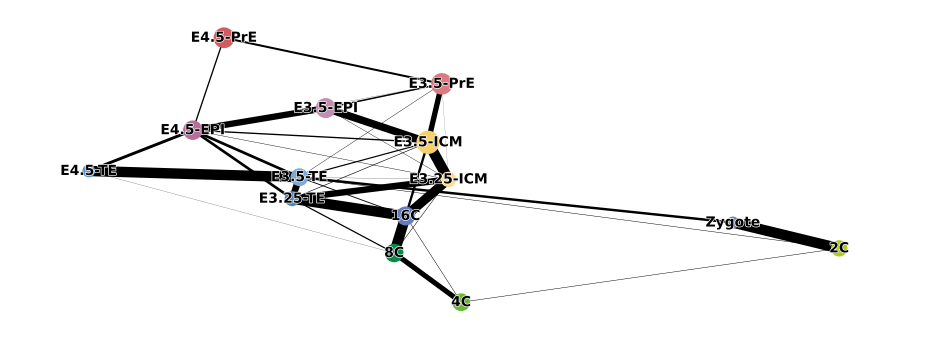

In [13]:
sc.pp.neighbors(combined, use_rep='X_scANVI')
sc.tl.draw_graph(combined)
sc.tl.umap(combined)
sc.tl.diffmap(combined)
sc.tl.paga(combined, groups='predictions')
sc.pl.paga(combined, color=['predictions'], frameon=False, fontoutline=True)
sc.tl.draw_graph(combined, init_pos='paga', n_jobs=10)

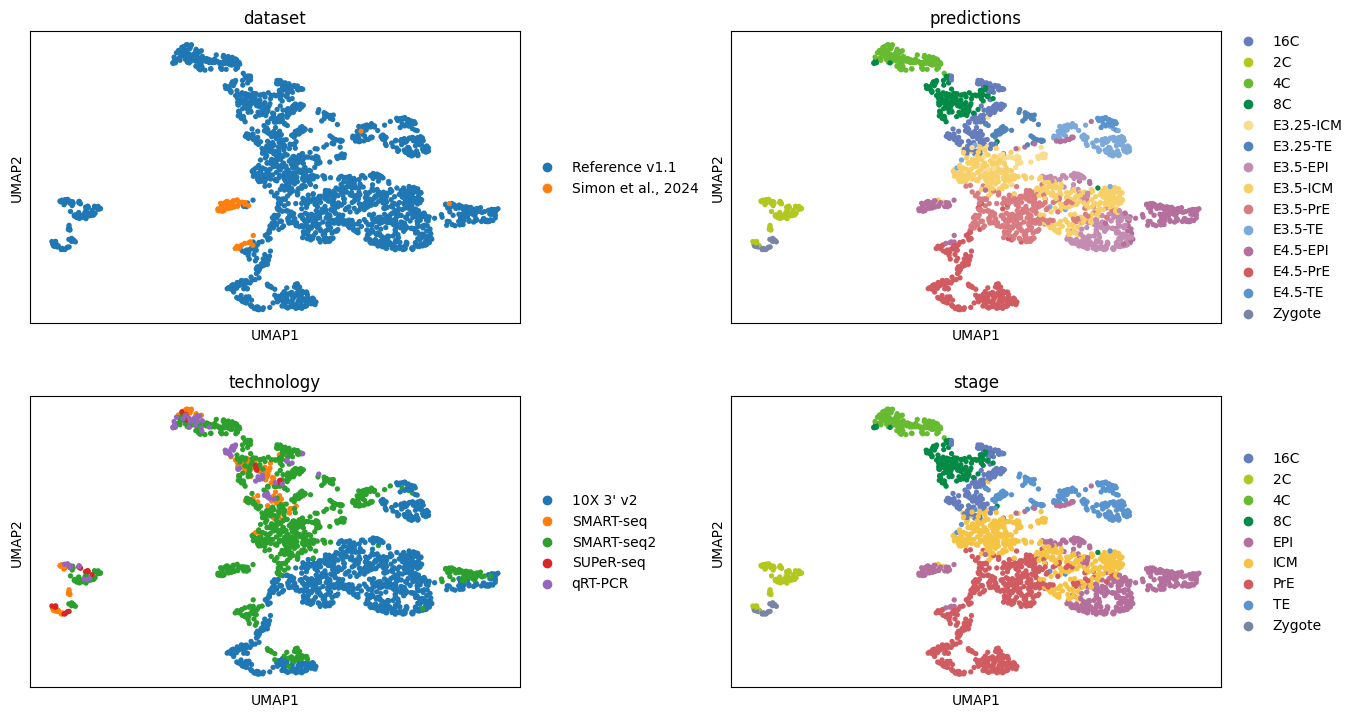

In [14]:
plt.rcParams['figure.figsize'] = [6, 4]
ax = sc.pl.umap(combined, color=['dataset', 'predictions', 'technology', 'stage'], ncols=2, wspace=0.3, return_fig=True)
ax.savefig('../figures/12_niakan_mouse_integration_umap.pdf')

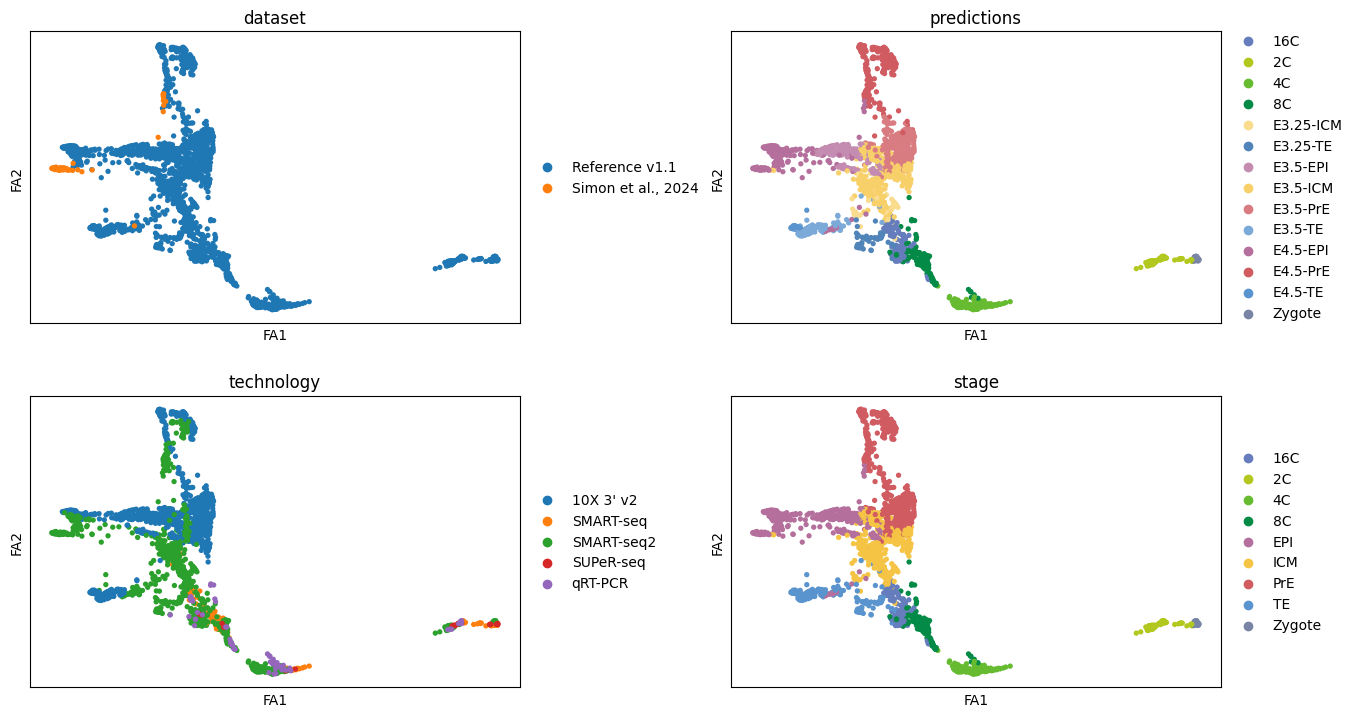

In [15]:
plt.rcParams['figure.figsize'] = [6, 4]
ax = sc.pl.draw_graph(combined, color=['dataset', 'predictions', 'technology', 'stage'], ncols=2, wspace=0.3, return_fig=True)
ax.savefig('../figures/12_niakan_mouse_integration_FA.pdf')

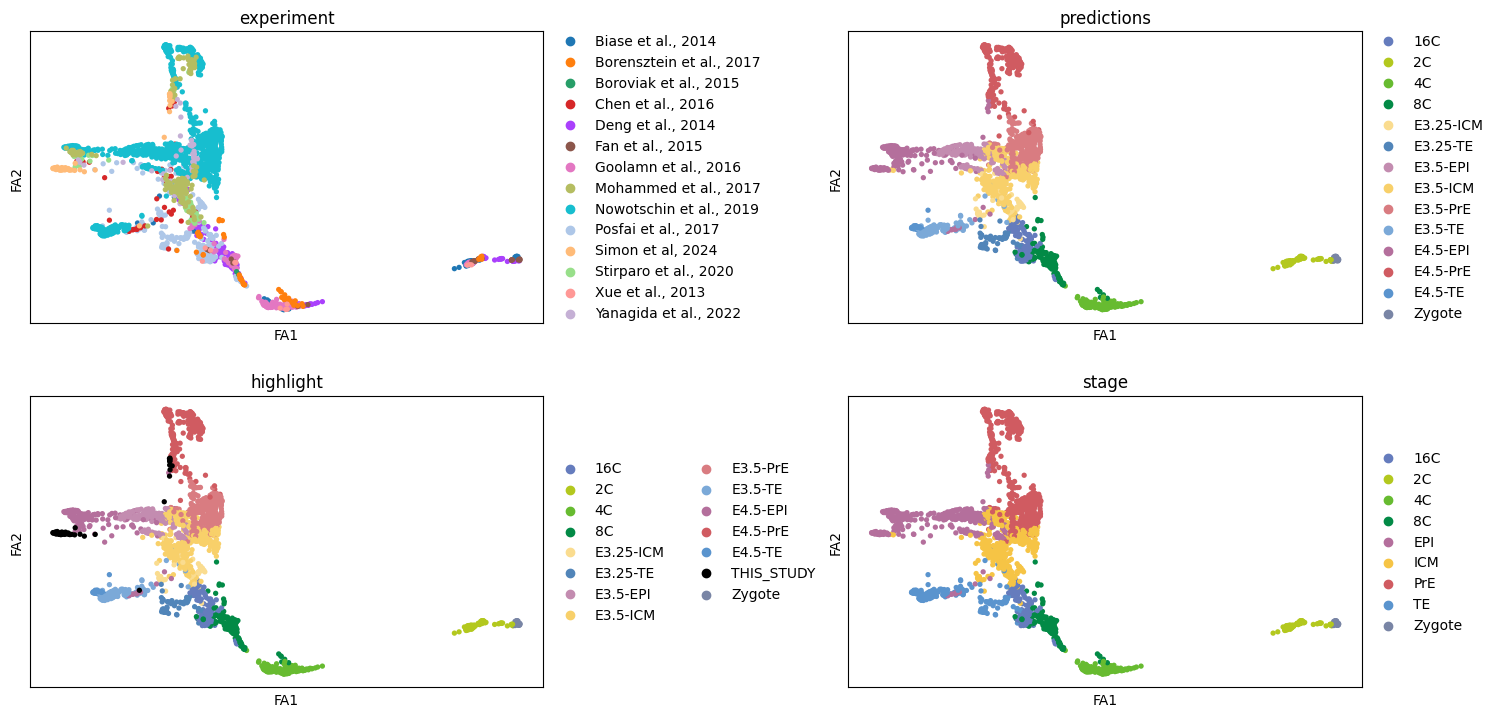

In [16]:
plt.rcParams['figure.figsize'] = [6, 4]
ax = sc.pl.draw_graph(combined, color=['experiment', 'predictions', 'highlight', 'stage'], ncols=2, wspace=0.45, return_fig=True)
ax.savefig('../figures/12_niakan_mouse_integration_FA_2.pdf')

### Pseudotime

In [17]:
merged_subset = combined[combined.obs.predictions.str.contains('ICM|PrE|EPI')].copy()
merged_subset.obs['treatment'] = 'None'
merged_subset.obs.loc[merged_subset.obs_names.intersection(mouse_query.obs_names), 'treatment'] = mouse_query.obs.loc[merged_subset.obs_names.intersection(mouse_query.obs_names), 'Treatment'].values
merged_subset.uns['treatment_colors'] = ['tab:blue', 'lightgrey', 'tab:orange']

merged_subset

AnnData object with n_obs × n_vars = 1325 × 3000
    obs: 'batch', 'experiment', 'technology', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'ct_custom', '_scvi_batch', '_scvi_labels', 'predictions', 'dataset', 'stage', 'highlight', 'treatment'
    uns: 'predictions_colors', 'stage_colors', 'highlight_colors', 'neighbors', 'draw_graph', 'umap', 'diffmap_evals', 'paga', 'predictions_sizes', 'dataset_colors', 'technology_colors', 'experiment_colors', 'treatment_colors'
    obsm: 'X_scANVI', 'X_draw_graph_fa', 'X_umap', 'X_diffmap'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

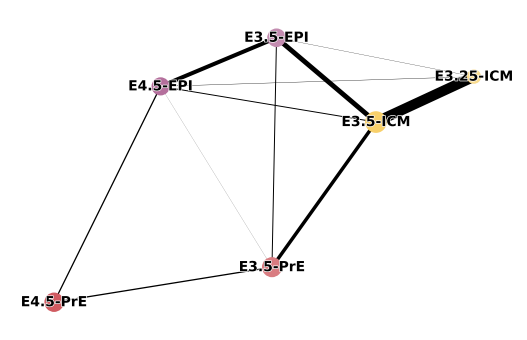

In [18]:
sc.pp.neighbors(merged_subset, use_rep="X_scANVI")
sc.tl.umap(merged_subset)
sc.tl.diffmap(merged_subset)

sc.tl.paga(merged_subset, groups='predictions')
sc.pl.paga(merged_subset, color='predictions', frameon=False, fontoutline=True)
sc.tl.draw_graph(merged_subset, init_pos='paga')

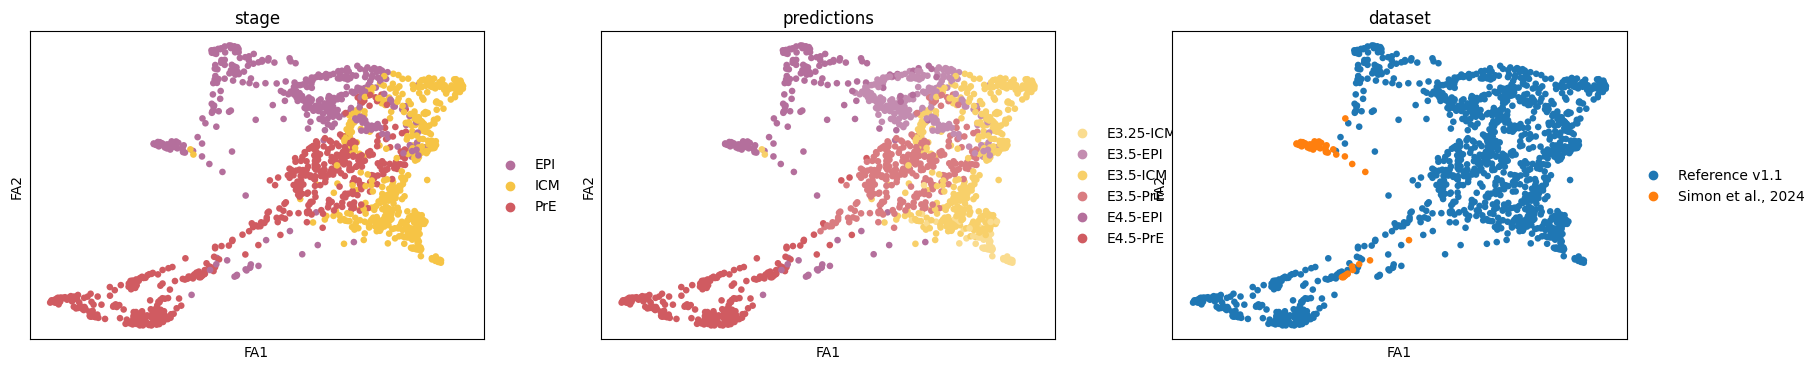

In [19]:
sc.pl.draw_graph(merged_subset, color=['stage', 'predictions', 'dataset'])

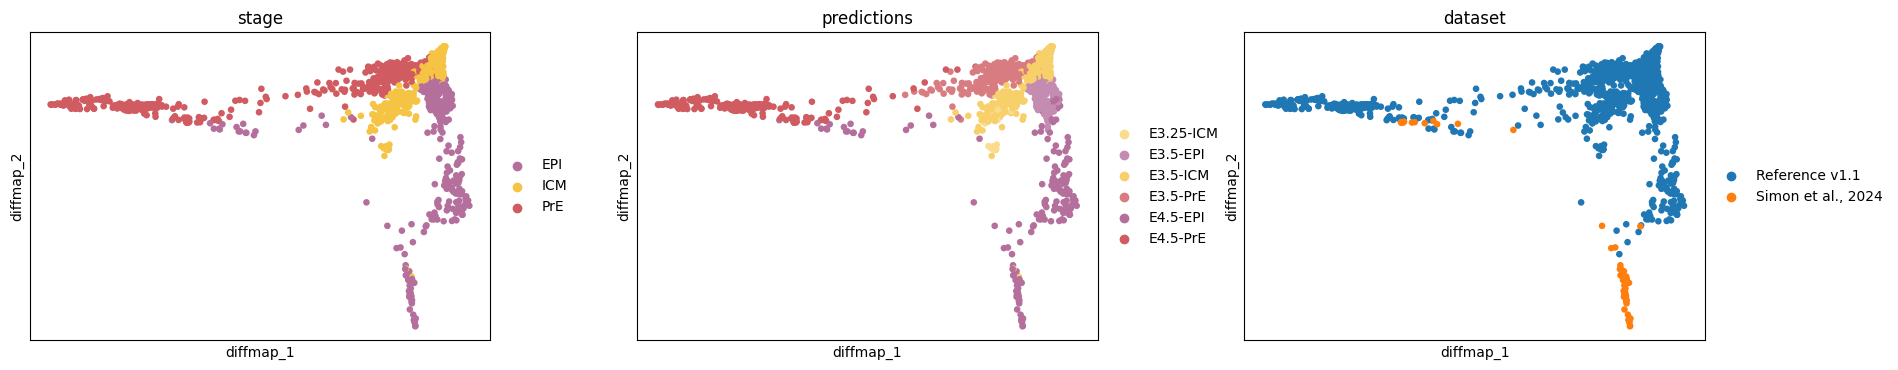

In [20]:
# sc.pl.diffmap(merged_subset, color=['stage', 'predictions', 'dataset'])

merged_subset.obsm["X_diffmap_"] = merged_subset.obsm["X_diffmap"][:, 1:]
sc.pl.embedding(merged_subset, "diffmap_", color=['stage', 'predictions', 'dataset'], wspace=0.2)

In [21]:
merged_subset.uns['iroot'] = np.flatnonzero(merged_subset.obs['predictions']  == 'E3.25-ICM')[0]
sc.tl.dpt(merged_subset)

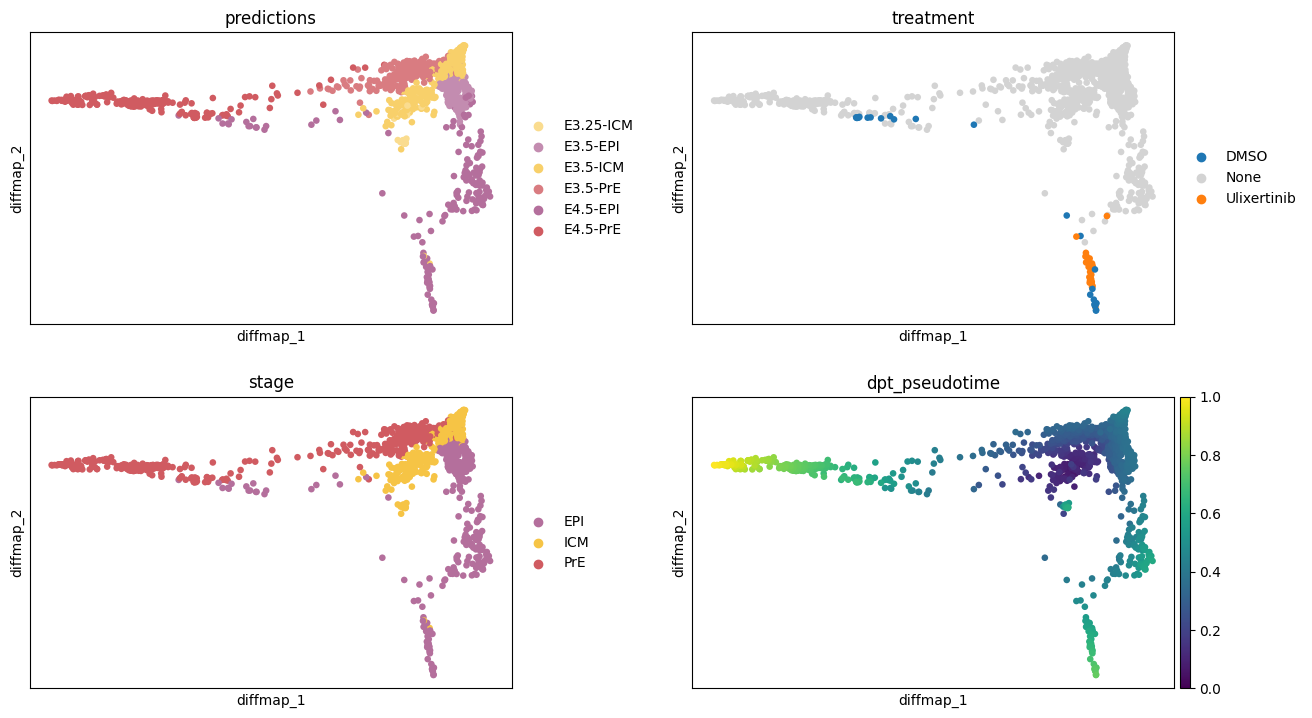

In [22]:
ax = sc.pl.embedding(merged_subset, "diffmap_", color=['predictions', 'treatment', 'stage', 'dpt_pseudotime'], ncols=2, wspace=0.25, return_fig=True)
ax.savefig('../figures/12_niakan_mouse_pseudotime_DC.pdf')
# ax = sc.pl.draw_graph(merged_subset, color=['predictions', 'treatment', 'stage', 'dpt_pseudotime'], ncols=2, wspace=0.25, return_fig=True)

In [23]:
adata = merged_subset[merged_subset.obs.predictions.str.contains('ICM|EPI')]
adata = adata[adata.obs.sort_values(by='dpt_pseudotime').index].copy()

In [24]:
df = adata.to_df()
df = (df - df.min()) / (df.max() - df.min())
df = df\
    .assign(predictions=adata.obs.predictions.cat.codes.to_numpy())\
    .assign(pseudotime=adata.obs.dpt_pseudotime.to_numpy())\
    .assign(treatment=adata.obs.treatment)\
    .assign(treatment_codes=adata.obs.treatment.cat.codes.to_numpy())\
    .assign(DMSO=adata.obs.treatment == 'DMSO')\
    .assign(Ulixertinib=adata.obs.treatment == 'Ulixertinib')
df['ps_bins'] = pd.cut(df.pseudotime, bins=np.arange(0, 1.1, 0.05))

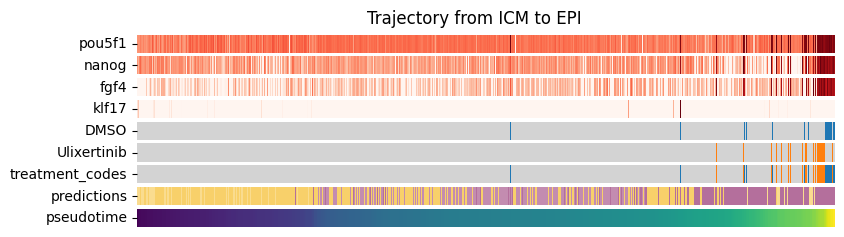

In [25]:
fig, ax = plt.subplots(9,1,figsize=(9,2.5))
for idx, gene in enumerate(['pou5f1', 'nanog', 'fgf4', 'klf17']):
    sns.heatmap(df[[gene]].T, cmap='Reds', cbar=False, xticklabels=False, ax=ax[idx])
sns.heatmap(df[['DMSO']].T, cbar=False, cmap=['lightgrey', 'tab:blue'], xticklabels=False, ax=ax[4])
sns.heatmap(df[['Ulixertinib']].T, cmap=['lightgrey', 'tab:orange'], cbar=False, xticklabels=False, ax=ax[5])
sns.heatmap(df[['treatment_codes']].T, cbar=False, cmap=list(adata.uns['treatment_colors']), xticklabels=False, ax=ax[6])
sns.heatmap(df[['predictions']].T, cbar=False, cmap=adata.obs.predictions.map(mouse_ct_colors).cat.categories.tolist(), xticklabels=False, ax=ax[7])
sns.heatmap(df[['pseudotime']].T, cmap='viridis', cbar=False, xticklabels=False, ax=ax[8])
for ax_ in ax:
    ax_.tick_params(axis='y', rotation=0)
fig.suptitle('Trajectory from ICM to EPI')
fig.savefig('../figures/12_niakan_mouse_pseudotime_ICM_EPI.pdf', bbox_inches='tight')

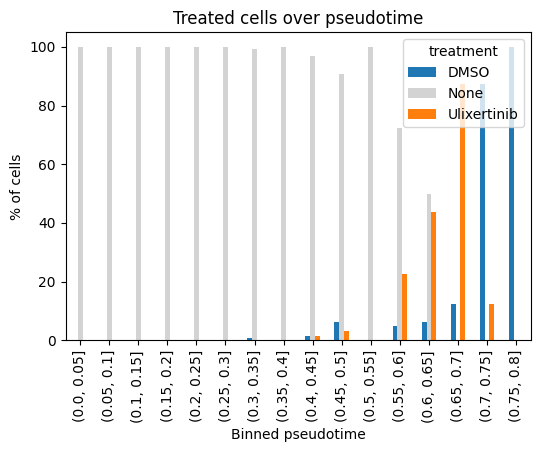

In [26]:
ax = (pd.crosstab(df.ps_bins, df.treatment, normalize='index') * 100).plot.bar(color=['tab:blue', 'lightgrey', 'tab:orange'], title='Treated cells over pseudotime', xlabel='Binned pseudotime', ylabel='% of cells')
ax.figure.savefig('../figures/12_niakan_mouse_pseudotime_ICM_EPI_treatment.pdf', bbox_inches='tight')

## Save additional stuff

In [27]:
adata = sc.read_h5ad('../results/12_niakan.mouse.withPredictions.h5ad')

counts = sc.read_h5ad("../data/assays/SCR_MP_20241207/processed/combined_matrix.h5ad")
counts.var['gene_id'] = counts.var_names
counts.var_names = counts.var.gene_symbol.str.lower().values
counts.var_names_make_unique()

counts = counts[adata.obs_names, adata.var_names].copy()
counts.obs = adata.obs.copy()
counts.var = adata.var.copy()

counts.layers['counts'] = counts.X.copy()

sc.pp.normalize_total(counts, target_sum=1_000_000)
counts.write('../results/12_niakan.mouse.PRM_withPredictions.h5ad')